In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
#kz.utils.set_matplotlib(style='default', usetex=False)

'/tigress/jiaxuanl/Data/HSC/LSBG'

In [7]:
lsbg_cat = Table.read('./Catalog/tiny_sample/tiny_sample_cutout_cat_tiny_sample.fits')
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 62


In [212]:
lsbg = lsbg_cat[5]

### Running scarlet vanilla modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/tiny_sample/tiny_sample_42`
    Working directory: /tigress/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    10 stars from Gaia are masked!
    Detected 129 objects
    10 stars from Gaia are masked!
    Detected 93 objects
    Detected 61 objects
    Total number of sources: 1
    Optimizaiton: Succeed for e_rel = 0.0001 with 44 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 84 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 5e-05 with 144 iterations! Try higher accuracy!
  - After 64 iterations, logL = 1141272.70
    Elapsed time for fitting: 35.46 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/tiny_sample/tiny

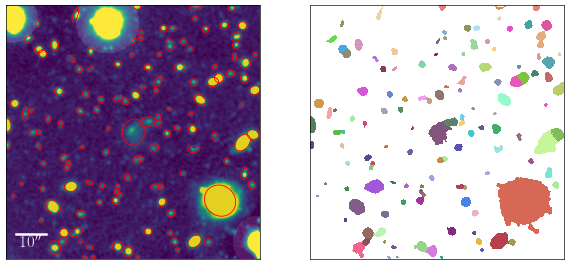

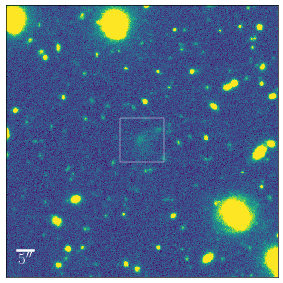

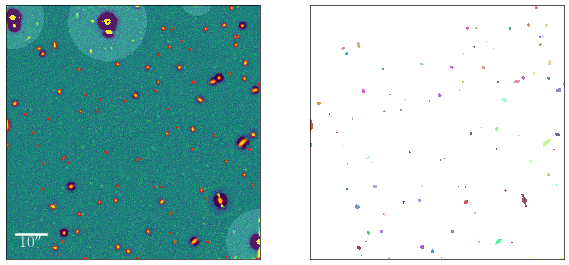

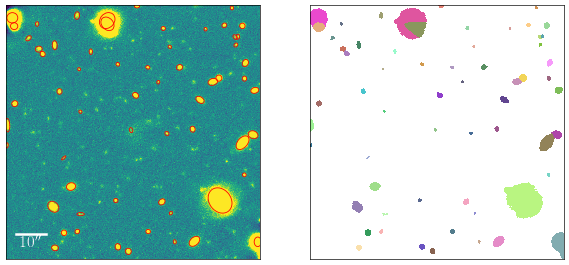

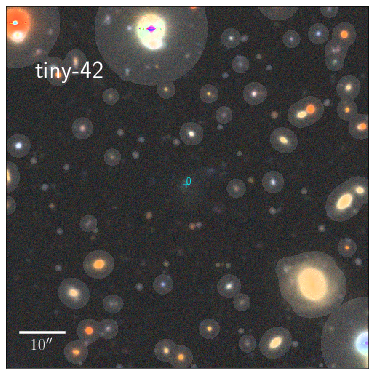

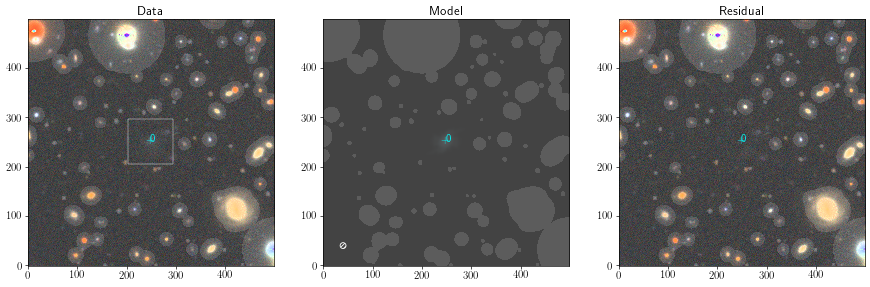

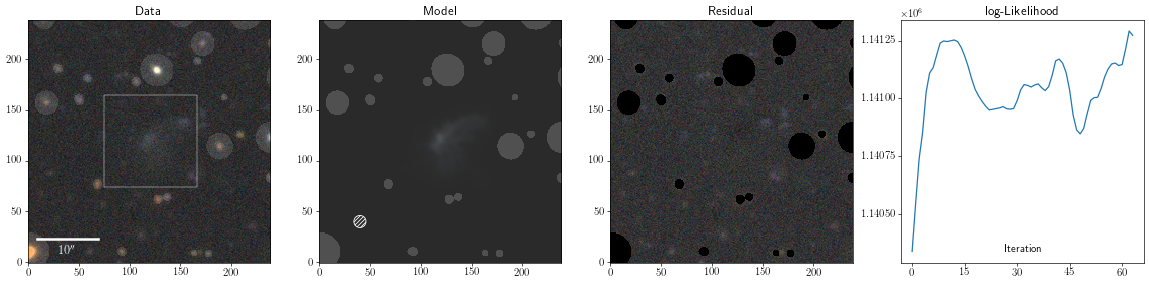

In [211]:
fitting_obs_tigress(env_dict,
                    lsbg,
                    name='viz-id',
                    method='vanilla', 
                    prefix='tiny', 
                    model_dir='./Model/tiny_sample/',
                    figure_dir='./Figure/tiny_sample/',
                    log_dir='./log/tiny_sample/',
                    show_figure=True)

In [15]:
import dill
from kuaizi.measure import makeMeasurement
from kuaizi.measure import fn

In [158]:
ind = 43

In [159]:
with open(f'/tigress/jiaxuanl/Data/HSC/LSBG/Model/tiny_sample/tiny-{ind}-trained-model-vanilla.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

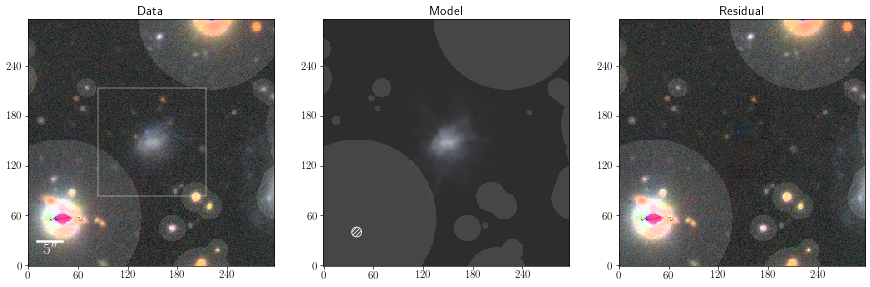

In [160]:
kz.display.display_scarlet_model(
    blend,
    show_ind=[0],
    zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False)

In [25]:
measurement, _ = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 makesegmap=True, sigma=0.5,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=False, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [26]:
-2.5 * np.log10(measurement['flux_circ'][2]) + 27.0, lsbg_cat[ind]['imag']

(21.465010166168213, 21.49)

In [27]:
measurement['rhalf_circularized'] * 0.168, lsbg_cat[ind]['Reff'] * np.sqrt(1 - lsbg_cat[ind]['Ell'])

(2.98395778721129, 2.4335313846342723)

In [28]:
measurement['SB_eff_avg'][2], lsbg_cat[ind]['iSB'] + 2.5 * np.log10(fn(lsbg_cat[ind]['n']))

(25.834423, 25.407502244756582)

In [213]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [214]:
fitter = ScarletFitter(method='vanilla', tigress=True, starlet_thresh=0.5,
                       model_dir='./Model/tiny_sample/',
                        figure_dir='./Figure/tiny_sample/',
                        log_dir='./log/tiny_sample',
                       prefix='tiny', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

#### Step-by-step

In [215]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!


In [216]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 116 objects


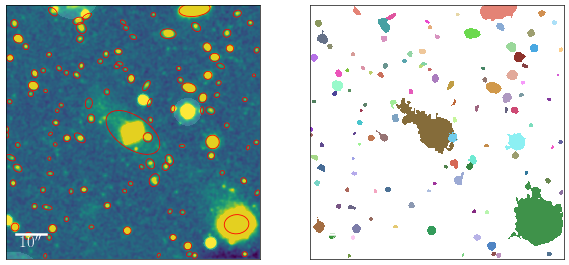

In [217]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.02
        
fitter._first_detection(first_dblend_cont)

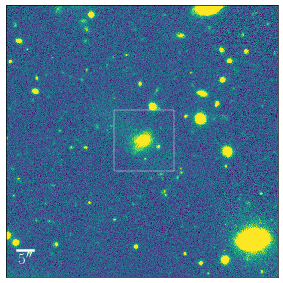

In [218]:
fitter._estimate_box(fitter.cen_obj)

In [219]:
fitter._mask_stars_outside_box()

    8 stars from Gaia are masked!


    Detected 73 objects


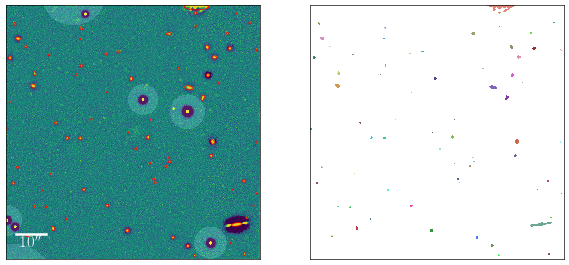

In [220]:
fitter._cpct_obj_detection()

    Detected 39 objects


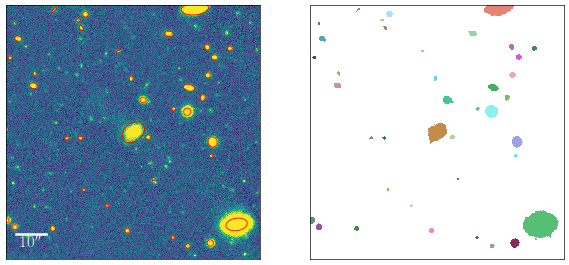

In [221]:
fitter._big_obj_detection()

In [222]:
fitter._merge_catalogs()

In [223]:
fitter._construct_obs_frames()

In [224]:
import sep
from astropy.convolution import convolve, Gaussian2DKernel

In [240]:
conv_data = np.zeros_like(fitter.data.images)
for i in range(len(fitter.data.images)):
    input_data = convolve(fitter.data.images[i].astype(float), Gaussian2DKernel(1.5))
    bkg = sep.Background(input_data, bw=32, bh=32, fw=3, fh=3)
    input_data -= bkg.globalback
    conv_data[i] = input_data

In [241]:
observation = scarlet.Observation(
    conv_data,
    wcs=fitter.data.wcs,
    psf=fitter.data.psfs,
    weights=fitter.data.weights,
    channels=list(fitter.data.channels))
fitter._conv_observation = observation.match(fitter.model_frame)

In [236]:
fitter._add_central_source(min_grad=0)[0].bbox

<Box shape=(4, 81, 81), origin=(0, 210, 212)>

In [237]:
fitter._add_sources()

    Total number of sources: 5


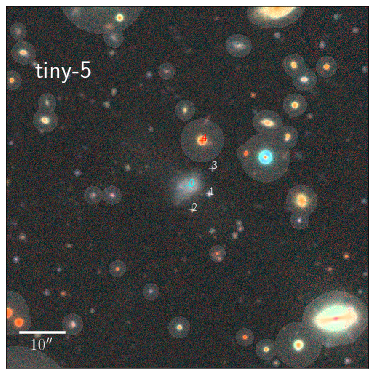

In [238]:
fig = kz.display.display_scarlet_sources(
        fitter.data,
        fitter._sources,
        show_ind=None,
        stretch=1,
        Q=1,
        minimum=-0.3,
        show_mark=True,
        scale_bar_length=10,
        add_text=f'{fitter.prefix}-{fitter.index}')

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

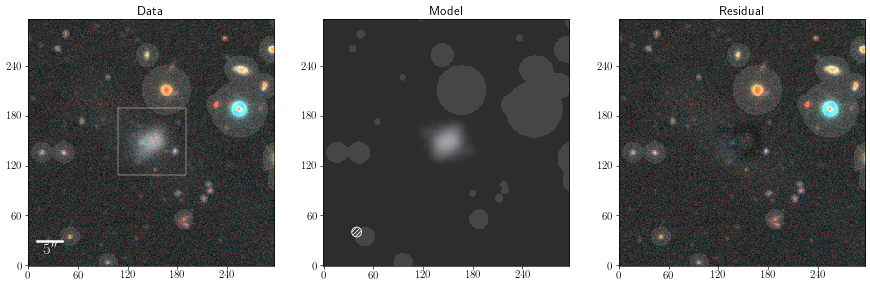

In [239]:
kz.display.display_scarlet_model(
    fitter.blend,
    show_ind=[0],
    zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False)

    Optimizaiton: Succeed for e_rel = 0.0001 with 71 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 116 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 5e-05 with 201 iterations! Try higher accuracy!
  - After 31 iterations, logL = 733190.79
    Elapsed time for fitting: 67.91 s


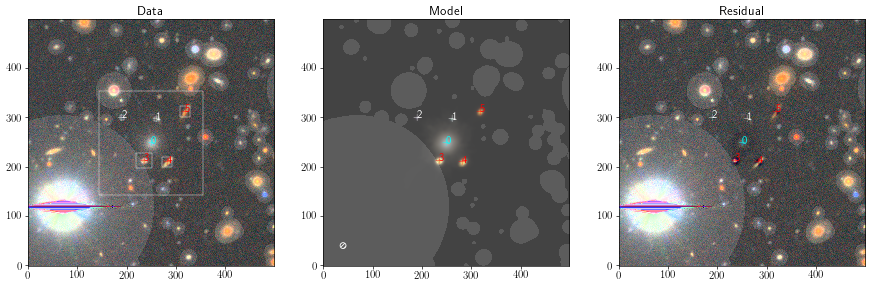

In [197]:
fitter._optimize()

In [198]:
fitter._find_sed_ind()

  - Components [0] are considered as the target galaxy.


In [199]:
fitter._gen_final_mask()

  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/tiny_sample/tiny-50-trained-model-vanilla.df


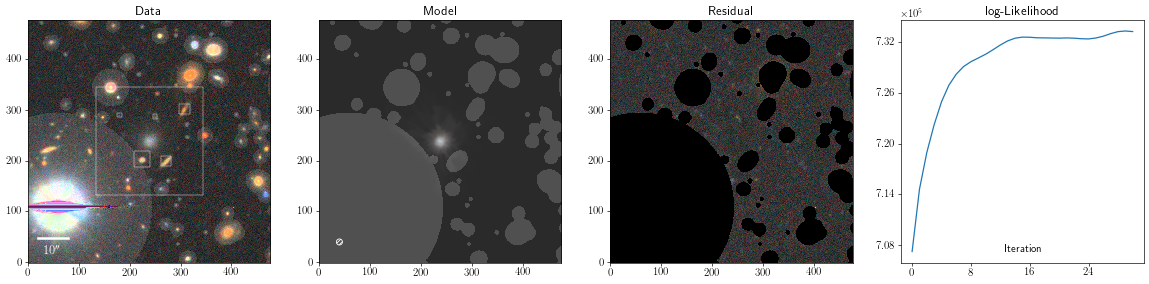

In [200]:
fitter._display_results()